# Scikit-learn決策樹演算法

## 載入相關套件

In [26]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import math

## 載入資料集

In [27]:
ds = datasets.load_wine()
feature_names = ds.feature_names
X, y = ds.data, ds.target

## 資料分割

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

## 模型訓練

In [29]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier() #criterion='entropy')
clf.fit(X_train, y_train)

DecisionTreeClassifier()

## 模型評分

In [30]:
# 計算準確率
y_pred = clf.predict(X_test)
print(f'{accuracy_score(y_test, y_pred)*100:.2f}%') 

88.89%


## 繪製樹狀圖

[Text(0.4, 0.9, 'alcohol <= 12.78\ngini = 0.653\nsamples = 142\nvalue = [45, 60, 37]'),
 Text(0.2, 0.7, 'color_intensity <= 4.84\ngini = 0.203\nsamples = 61\nvalue = [0, 54, 7]'),
 Text(0.1, 0.5, 'gini = 0.0\nsamples = 52\nvalue = [0, 52, 0]'),
 Text(0.3, 0.5, 'proline <= 467.5\ngini = 0.346\nsamples = 9\nvalue = [0, 2, 7]'),
 Text(0.2, 0.3, 'gini = 0.0\nsamples = 2\nvalue = [0, 2, 0]'),
 Text(0.4, 0.3, 'gini = 0.0\nsamples = 7\nvalue = [0, 0, 7]'),
 Text(0.6, 0.7, 'flavanoids <= 1.49\ngini = 0.549\nsamples = 81\nvalue = [45, 6, 30]'),
 Text(0.5, 0.5, 'gini = 0.0\nsamples = 30\nvalue = [0, 0, 30]'),
 Text(0.7, 0.5, 'proline <= 682.5\ngini = 0.208\nsamples = 51\nvalue = [45, 6, 0]'),
 Text(0.6, 0.3, 'gini = 0.0\nsamples = 5\nvalue = [0, 5, 0]'),
 Text(0.8, 0.3, 'magnesium <= 135.5\ngini = 0.043\nsamples = 46\nvalue = [45, 1, 0]'),
 Text(0.7, 0.1, 'gini = 0.0\nsamples = 45\nvalue = [45, 0, 0]'),
 Text(0.9, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]')]

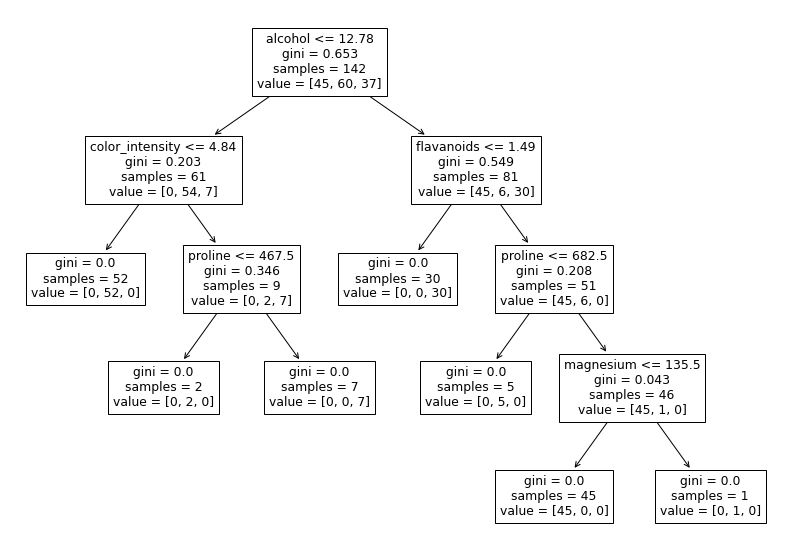

In [33]:
import matplotlib.pyplot as plt

from sklearn.tree import plot_tree
plt.figure(figsize=(14,10))
plot_tree(clf, feature_names=feature_names)

## 使用 graphviz 繪製圖形
### 安裝
1. 安裝 graphviz (https://graphviz.org/download/) 
2. 將安裝路徑的bin加入環境變數Path中(C:\Program Files (x86)\Graphviz2.XX\bin)
3. pip install graphviz pydotplus

In [37]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(clf,
                           filled=True, 
                           rounded=True,
                           class_names=ds.target_names,
                           feature_names=ds.feature_names,
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('wine_tree.png') 

True

## 顯示樹狀圖檔

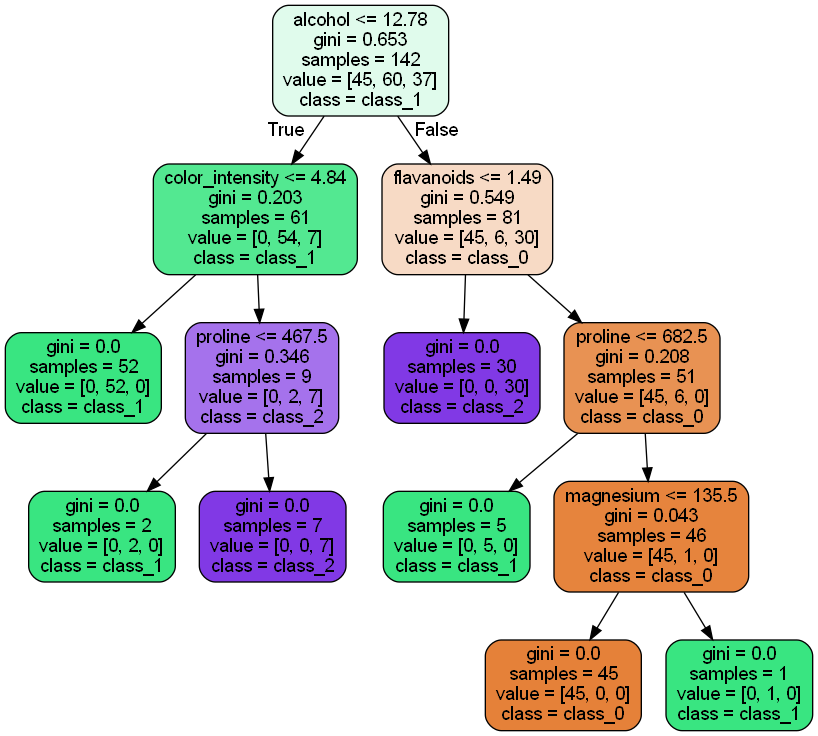

In [41]:
from IPython.display import Image
Image(filename='wine_tree.png', width=500) 

## dot 格式存檔

In [42]:
dot_data = export_graphviz(clf,
                           filled=True, 
                           rounded=True,
                           class_names=ds.target_names,
                           feature_names=ds.feature_names,
                           out_file='wine_tree.dot') 

## 取得樹狀圖的相關資訊

In [55]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print(f"樹狀圖共有{n_nodes}個節點:")
for i in range(n_nodes):
    depth = node_depth[i] * '\t'
    if is_leaves[i]:
        print(f"{depth}node={i} leaf node.")
    else:
        print(f"{depth}node={i} child node: go to node {children_left[i]} if X[:, " \
              + f"{feature[i]}] <= {threshold[i]} else to node {children_right[i]}.")
print()

node_indicator = clf.decision_path(X)
leave_id = clf.apply(X)
sample_id = 0
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print(f'Rules used to predict sample {sample_id}: ')
for node_id in node_index:
    if leave_id[sample_id] == node_id:
        continue

    if (X[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision id node {} : (X[{}, {}] (= {}) {} {})"
          .format(node_id,
             sample_id,
             feature[node_id],
             X[sample_id, feature[node_id]],
             threshold_sign,
             threshold[node_id]))

# For a group of samples, we have the following common node.
sample_ids = [0, 1]
common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
                len(sample_ids))

common_node_id = np.arange(n_nodes)[common_nodes]

print("\nThe following samples %s share the node %s in the tree"
      % (sample_ids, common_node_id))
print("It is %s %% of all nodes." % (100 * len(common_node_id) / n_nodes,))

樹狀圖共有13個節點:
node=0 child node: go to node 1 if X[:, 0] <= 12.78000020980835 else to node 6.
	node=1 child node: go to node 2 if X[:, 9] <= 4.8399999141693115 else to node 3.
		node=2 leaf node.
		node=3 child node: go to node 4 if X[:, 12] <= 467.5 else to node 5.
			node=4 leaf node.
			node=5 leaf node.
	node=6 child node: go to node 7 if X[:, 6] <= 1.4900000095367432 else to node 8.
		node=7 leaf node.
		node=8 child node: go to node 9 if X[:, 12] <= 682.5 else to node 10.
			node=9 leaf node.
			node=10 child node: go to node 11 if X[:, 4] <= 135.5 else to node 12.
				node=11 leaf node.
				node=12 leaf node.

Rules used to predict sample 0: 
decision id node 0 : (X[0, 0] (= 14.23) > 12.78000020980835)
decision id node 6 : (X[0, 6] (= 3.06) > 1.4900000095367432)
decision id node 8 : (X[0, 12] (= 1065.0) > 682.5)
decision id node 10 : (X[0, 4] (= 127.0) <= 135.5)

The following samples [0, 1] share the node [ 0  6  8 10 11] in the tree
It is 38.46153846153846 % of all nodes.
